# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import time
import requests
import re
from datetime import datetime
from datetime import timedelta
import collections, numpy

pd.set_option('display.max_columns', None)

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Location','Date','Time','Request','Status','Size','Referer','UserAgent'], engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [3]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN


In [4]:
Logs_copy.shape

(261873, 10)

In [5]:
Logs_copy.isnull().sum()

DNS               0
IP                0
Location          0
Date              0
Time              0
Request      261387
Status       261872
Size         261872
Referer      261873
UserAgent    261873
dtype: int64

In [6]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN


In [7]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN,NaN


In [8]:
# Reorder columns of data

Logs_copy.UserAgent = Logs_copy.Time
Logs_copy.Request = Logs_copy.Location
Logs_copy.Referer = Logs_copy.Date
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = Logs_copy.Location = np.nan

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,NaN,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost 127.0.0.1,NaN,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost 127.0.0.1,NaN,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost 127.0.0.1,NaN,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost 127.0.0.1,NaN,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [9]:
# DNS & IP data split

Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [10]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [11]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'akumenius.com', 'akumenius.es',
       'test.akumenius.com'], dtype=object)

In [12]:
len(Logs_copy.IP.unique())

2921

In [13]:
# Time data extraction

Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

#Logs_copy.Time = pd.to_datetime(Logs_copy.Time, format = '%H:%M:%S %z')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [14]:
# Date data extraction

Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

#Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [15]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [16]:
# Request & Status data split

Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [17]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,NaN,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200 7528,None,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,NaN,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,None,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [18]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [19]:
# Size data extraction

Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [20]:
# Clean Size data
start = time.monotonic()

sizes = []

for index, row in Logs_copy.iterrows(): 
    
    #if re.search('200', row.Size):
    if row.Size == '200':
        sizes.append(np.nan)
    else:
        sizes.append(row.Size)

Logs_copy.Size = sizes

end = time.monotonic()

print(timedelta(seconds = end - start))

Logs_copy.head()

0:00:25.302100


,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [21]:
# Status data extraction

Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,NaN,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,NaN,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [22]:
# Clean Referer data

start = time.monotonic()

referers = []

for index, row in Logs_copy.iterrows(): 
    
    if re.search('-"', row.Referer):
        referers.append(np.nan)
    else:
        referers.append(row.Referer.rstrip(row.Referer[-1]))

    

Logs_copy.Referer = referers

In [23]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,NaN,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,NaN,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,NaN,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [IP2Locattion](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

In [24]:
Ips_export= Logs_copy.IP.copy()

Ips_export.replace('', 'null', inplace = True)

Ips_export.to_csv('../Data/Ips_export.csv', index = False)

- Extración de Localizaciones en el siguiente archivo:
  - [Extract_Locattion](https://github.com/jesussantana/Registre_de_logs/blob/main/Tasca_7_Registre_de_Logs_Ips_Exercici3.ipynb)

- Recuperación del archivo de las Localizaciones extraidas

In [25]:
path = '../Data/Locations_export.csv'

Locations_raw = pd.read_csv(path, sep='delimiter', names =['Location'], engine='python')

Locations_raw

,Location
0,Locations
1,"""('Local', 'Local')"""
2,"""('Local', 'Local')"""
3,"""('Local', 'Local')"""
4,"""('Local', 'Local')"""
...,...
261869,""""""
261870,""""""
261871,""""""
261872,""""""


In [26]:
Locations_copy = Locations_raw.drop([0],axis=0)
Locations_copy

,Location
1,"""('Local', 'Local')"""
2,"""('Local', 'Local')"""
3,"""('Local', 'Local')"""
4,"""('Local', 'Local')"""
5,"""('Local', 'Local')"""
...,...
261869,""""""
261870,""""""
261871,""""""
261872,""""""


In [27]:
Logs_copy.Location = Locations_copy.Location

In [28]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


In [29]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,"""""",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,"""""",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


In [30]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,"""""",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,"""""",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

In [31]:
# Extract UserAgent Data

from device_detector import SoftwareDetector

Devices = Logs_copy.UserAgent
device = []

for x in Devices:
    
    device.append(SoftwareDetector(x).parse())

client_name = []
client_type = []
client_version = []
os_name = []
os_version = []
device_type = []

for x in device:
    
    client_name.append(x.client_name())
    client_type.append(x.client_type())
    client_version.append(x.client_version())
    os_name.append(x.os_name())
    os_version.append(x.os_version())
    device_type.append(x.device_type())

Logs_copy['Client_Name'] = client_name
Logs_copy['Client_Type'] = client_type
Logs_copy['Client_Version'] = client_version
Logs_copy['Os_Name'] = os_name
Logs_copy['Os_Version'] = os_version
Logs_copy['Device_Type'] = device_type

Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
2,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
3,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
4,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,"""""",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,YandexBot,generic,3.0,,,
261869,www.akumenius.com,74.86.158.107,"""""",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,UptimeRobot,generic,2.0,,,
261870,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
261871,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,


In [32]:
Logs_copy.UserAgent[0]

'Apache (internal dummy connection)" VLOG=-'

In [33]:
del(Logs_copy['UserAgent'])

Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
261868,www.akumenius.com,5.255.253.53,"""""",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,YandexBot,generic,3.0,,,
261869,www.akumenius.com,74.86.158.107,"""""",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,UptimeRobot,generic,2.0,,,
261870,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
261871,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
261872,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,


In [34]:
# Clean Client Data
client = []

for index, row in Logs_copy.iterrows(): 
    
    if re.search('Apache', row.Client_Name):
        client.append(row.Client_Name[0:6])
    else:
        client.append(row.Client_Name)

Logs_copy.Client_Name = client

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
1,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
2,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
3,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
4,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,


In [35]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client_Name,Client_Type,Client_Version,Os_Name,Os_Version,Device_Type
0,localhost,127.0.0.1,NaN,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
1,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
2,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
3,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
4,localhost,127.0.0.1,"""('Local', 'Local')""",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,"""""",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,YandexBot,generic,3.0,,,
261869,www.akumenius.com,74.86.158.107,"""""",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,UptimeRobot,generic,2.0,,,
261870,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,
261871,localhost,127.0.0.1,"""""",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache,generic,None,,,


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/jesus/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='Location'>

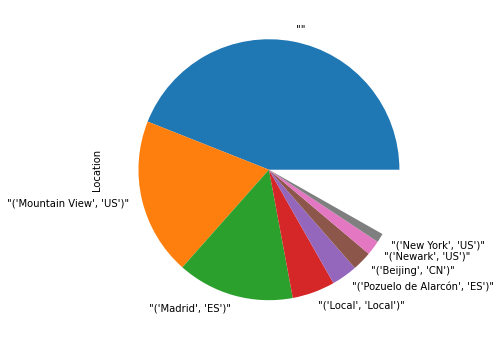

In [53]:

Logs_copy.Location.value_counts(normalize=True).where(Logs_copy.Location.value_counts() > 2000).plot(kind = 'pie', figsize = (10,6))

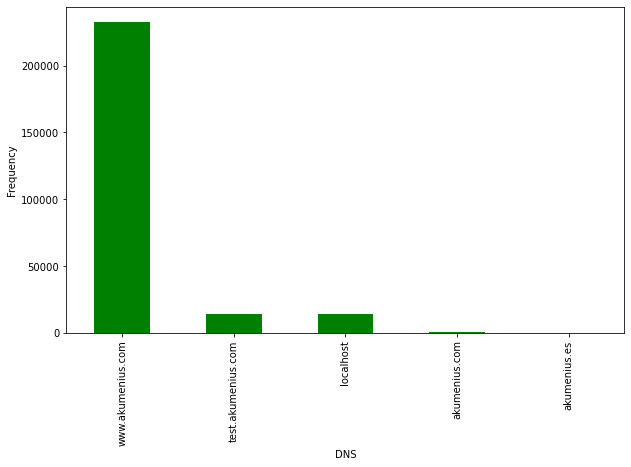

In [38]:
graph = Logs_copy[['DNS', 'Location']].groupby(['DNS']).count().sort_values(by = 'Location',ascending = False)
graph = graph.rename(columns = {'Location' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

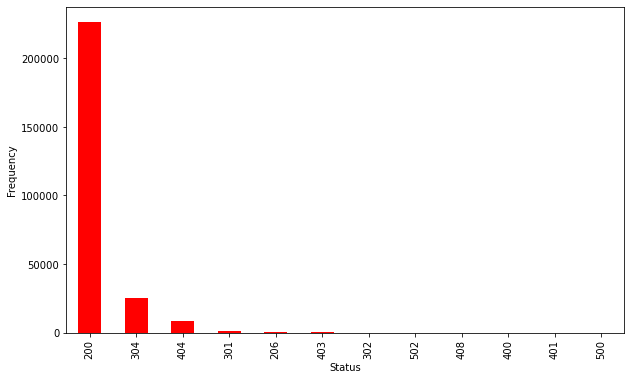

In [39]:
graph = Logs_copy[['Status', 'Time']].groupby(['Status']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

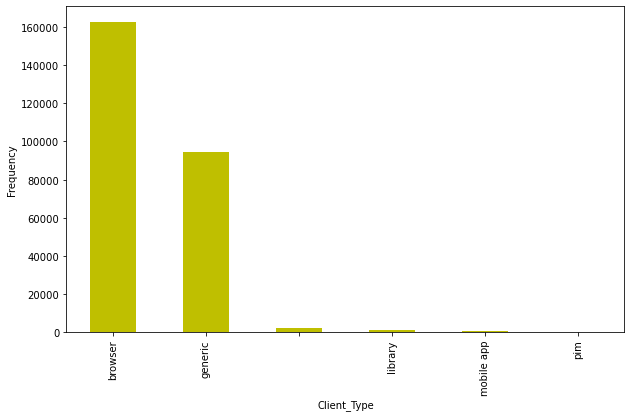

In [40]:
graph = Logs_copy[['Client_Type', 'Time']].groupby(['Client_Type']).count().sort_values(by = 'Time',ascending = False)
graph = graph.rename(columns = {'Time' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'y', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

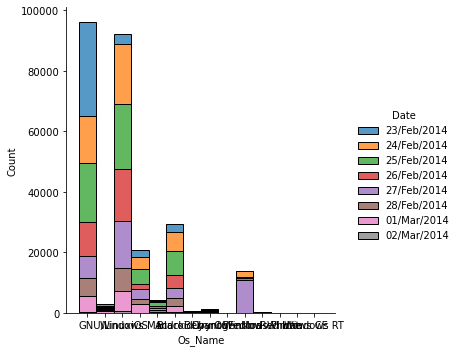

In [41]:
sns.displot(data = Logs_copy, x = "Os_Name", hue = "Date", multiple = "stack")

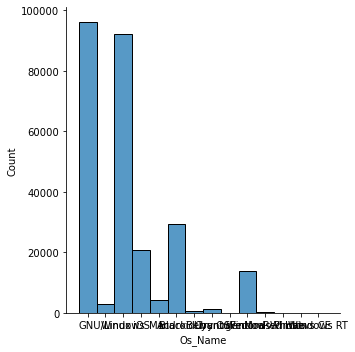

In [42]:
sns.displot(Logs_copy.Os_Name)

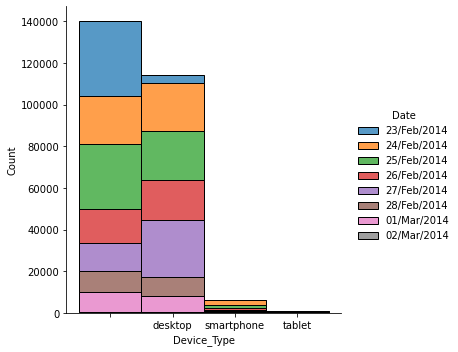

In [43]:
sns.displot(data = Logs_copy, x = "Device_Type", hue = "Date", multiple = "stack")

In [44]:
Logs_export = Logs_copy.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)